In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from math import nan
import pandas as pd

from qtrendutils import linfit_utils as linfit
from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import calendar_utils as cal

import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='Arial')

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/"

### Read in the land fraction

In [3]:
landfrac = xr.open_dataset("/project/cas/islas/cesm2le/fx/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)

### Read in the US southwest data

In [4]:
### ISD
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
isd_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
isd_sw_lons = isd_vp_swstat.lons ; isd_sw_lats = isd_vp_swstat.lats ; isd_sw_wgts = isd_vp_swstat.area_weights
isd_vp_swstat = isd_vp_swstat.drop_vars(['lons','lats', 'area_weights'])

# compute the seasonal cycle
isd_sw_seascyc = isd_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_sw_deseas = isd_vp_swstat.groupby('time.month') - isd_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
isd_sw_seascyc = isd_sw_seascyc.rename({"month":"time"})
isd_sw_seascyc['time'] = isd_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_sw_seascyc_am = cal.calcannualmean(isd_sw_seascyc)

# annual average of deseasonzlied anomalies
isd_sw_deseas_am = cal.calcannualmean(isd_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_sw_seascyc_am = isd_sw_seascyc_am.expand_dims({"otheryrs":isd_sw_deseas_am.year.size})
isd_sw_seascyc_am = isd_sw_seascyc_am.stack(z=("year","otheryrs"))
isd_sw_seascyc_am = isd_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
isd_sw_seascyc_am = isd_sw_seascyc_am.assign_coords({'year':isd_sw_deseas_am.year})

# add back in the annual average climatology
isd_sw_am = isd_sw_seascyc_am + isd_sw_deseas_am

isd_sw_am = xr.merge([isd_sw_am, isd_sw_lons, isd_sw_lats, isd_sw_wgts]) 

# now take the average over stations
isd_vp_sw_am = (isd_sw_am*isd_sw_am.area_weights).sum('station') / np.sum(isd_sw_am.area_weights)
isd_vp_sw_am = isd_vp_sw_am.drop_vars(['lons','lats','area_weights'])

In [5]:
### HadISDH
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
hadisdh_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_HadISDH_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
hadisdh_sw_lons = hadisdh_vp_swstat.lon ; hadisdh_sw_lats = hadisdh_vp_swstat.lat ; hadisdh_sw_wgts = hadisdh_vp_swstat.area_weights
hadisdh_vp_swstat = hadisdh_vp_swstat.drop_vars(['lon','lat','area_weights'])

# compute the seasonal cycle
hadisdh_sw_seascyc = hadisdh_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_sw_deseas = hadisdh_vp_swstat.groupby('time.month') - hadisdh_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
hadisdh_sw_seascyc = hadisdh_sw_seascyc.rename({"month":"time"})
hadisdh_sw_seascyc['time'] = hadisdh_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_sw_seascyc_am = cal.calcannualmean(hadisdh_sw_seascyc)

# annual average of deseasonzlied anomalies
hadisdh_sw_deseas_am = cal.calcannualmean(hadisdh_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size})
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.assign_coords({'year':hadisdh_sw_deseas_am.year})

# add back in the annual average climatology
hadisdh_sw_am = hadisdh_sw_seascyc_am + hadisdh_sw_deseas_am

hadisdh_sw_am = xr.merge([hadisdh_sw_am, hadisdh_sw_lons, hadisdh_sw_lats, hadisdh_sw_wgts]) 

# now take the average over stations
hadisdh_vp_sw_am = (hadisdh_sw_am*hadisdh_sw_am.area_weights).sum('station') / np.sum(hadisdh_sw_am.area_weights)
hadisdh_vp_sw_am = hadisdh_vp_sw_am.drop_vars(['lon','lat','area_weights'])

In [6]:
era5_vp = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ERA5_USSW.nc").vp
#isd_vp = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd.nc").vp
gpcp = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/precip/GPCP_USSW.nc")
gpcc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/precip/GPCC_USSW.nc")
cruts = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/precip/CRUTS_USSW.nc")

lens2_vp = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_LENS2_USSW.nc")
lens2_pr = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/precip/pr_LENS2_USSW.nc")

cmip6_vp = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_CMIP6_USSW.nc")
cmip6_pr = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/precip/pr_CMIP6_USSW.nc")*86400.

goga2_vp = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/vaporpressures/vaporpressures_GOGA2_USSW.nc")
goga2_pr = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/precip/pr_GOGA2_USSW.nc")

cmip6info = pd.read_csv("/home/islas/python/qtrend_paper/DATA_SORT/CMIP6/cmip6csvinfo.csv")
models = cmip6info['Model']
nmems = cmip6info['Nmem']
nmemmax = np.max(cmip6info['Nmem'])
nmemscmip6 = nmems

### Calculate the annual mean

In [7]:
era5_vp_am = cal.calcannualmean(era5_vp)
#isd_vp_am = cal.calcannualmean(isd_vp)
gpcp_am = cal.calcannualmean(gpcp)
gpcc_am = cal.calcannualmean(gpcc)
cruts_am = cal.calcannualmean(cruts)

lens2_vp_am = cal.calcannualmean(lens2_vp)
lens2_pr_am = cal.calcannualmean(lens2_pr)

goga2_vp_am = cal.calcannualmean(goga2_vp)
goga2_pr_am = cal.calcannualmean(goga2_pr)

cmip6_vp_am = cal.calcannualmean(cmip6_vp)
cmip6_pr_am = cal.calcannualmean(cmip6_pr)

### Calculate the trends

In [8]:
era5_vp_trend = xr.apply_ufunc(linfit.compute_slope, era5_vp_am, vectorize=True, input_core_dims=[['year']])*era5_vp_am.year.size
isd_vp_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_am, vectorize=True, input_core_dims=[['year']])*isd_vp_sw_am.year.size
hadisdh_vp_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_vp_sw_am, vectorize=True, input_core_dims=[['year']])*hadisdh_vp_sw_am.year.size
gpcc_trend = xr.apply_ufunc(linfit.compute_slope, gpcc_am, vectorize=True, input_core_dims=[['year']])*gpcc_am.year.size
gpcp_trend = xr.apply_ufunc(linfit.compute_slope, gpcp_am, vectorize=True, input_core_dims=[['year']])*gpcp_am.year.size
cruts_trend = xr.apply_ufunc(linfit.compute_slope, cruts_am, vectorize=True, input_core_dims=[['year']])*cruts_am.year.size
lens2_vp_trend = xr.apply_ufunc(linfit.compute_slope, lens2_vp_am, vectorize=True, input_core_dims=[['year']])*lens2_vp_am.year.size
lens2_pr_trend = xr.apply_ufunc(linfit.compute_slope, lens2_pr_am, vectorize=True, input_core_dims=[['year']])*lens2_pr_am.year.size
goga2_vp_trend = xr.apply_ufunc(linfit.compute_slope, goga2_vp_am, vectorize=True, input_core_dims=[['year']])*goga2_vp_am.year.size
goga2_pr_trend = xr.apply_ufunc(linfit.compute_slope, goga2_pr_am, vectorize=True, input_core_dims=[['year']])*goga2_pr_am.year.size
cmip6_vp_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_vp_am, vectorize=True, input_core_dims=[['year']])*cmip6_vp_am.year.size
cmip6_pr_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_pr_am, vectorize=True, input_core_dims=[['year']])*cmip6_pr_am.year.size
nyears = era5_vp_am.year.size

### Read in the CMIP6 global vp and pr trends

In [9]:
vpglobal = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_CMIP6.nc").vp
vpglobal['lon'] = landfrac.lon ; vpglobal['lat'] = landfrac.lat
prglobal = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/prtrends_CMIP6.nc").pr
prglobal['lon'] = landfrac.lon ; prglobal['lat'] = landfrac.lat

vpglobal_stacked = vpglobal.stack(z=("model","member"))
prglobal_stacked = prglobal.stack(z=("model","member"))

testpoint = vpglobal_stacked.isel(lon=0, lat=0)
vpglobal_stacked = vpglobal_stacked.where( ~np.isnan(testpoint), drop=True)
prglobal_stacked = prglobal_stacked.where( ~np.isnan(testpoint), drop=True)

cmip6_vp_pr_cor = xr.corr(prglobal_stacked, vpglobal_stacked, dim='z')

### Read in the GPCP precipitation trends

In [10]:
gpcc_global = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/prtrends_GPCC.nc").pr
gpcc_global['lon'] = landfrac.lon ; gpcc_global['lat'] = landfrac.lat

#---setting the grid points that are identically zero to nan's because it was causing a plotting issue
gpcc_global = gpcc_global.where(gpcc_global != 0, nan)

### Set up the vp versus pr plot

In [13]:
def setup_vp_vs_pr(x1, x2, y1, y2, titlestr, yticks=True):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_ylim(-1,2.2)
    ax.set_xlim(-0.4,0.4)
    
    #ax.plot([0,0],[-1,2.2], color='black')
    #ax.plot([-0.4,0.4],[0,0], color='black')
    
    ax.set_yticks([-1,-0.5,0,0.5,1,1.5,2])
    ax.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])

    if (yticks):  
        ax.set_yticklabels(['-1.0','-0.5','0.0','0.5','1.0','1.5','2.0'], fontsize=11)
        ax.set_ylabel('Vapor pressure trend (hPa/'+str(nyears)+'y)', fontsize=11)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' ',' '], fontsize=11)
        
    ax.set_xticklabels(['-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4'], fontsize=11)
    
    ax.set_xlabel('Precipitation trend (mm/day/'+str(nyears)+'y)', fontsize=12)
    ax.set_title(titlestr, fontsize=13)
    
    return ax

In [14]:
cmip6colors=['rosybrown','lightcoral','indianred','firebrick','maroon','red','chocolate','saddlebrown','sandybrown','peachpuff','tan',
             'darkgoldenrod','gold','darkkhaki',
             'olive','yellowgreen','darkolivegreen','darkseagreen','palegreen','forestgreen','mediumseagreen','mediumaquamarine',
             'turquoise','lightseagreen','teal','cadetblue','powderblue','steelblue','dodgerblue','blue','slateblue','darkslateblue',
             'blueviolet','indigo','mediumorchid','plum','violet','purple','palevioletred','magenta','crimson','lightpink']

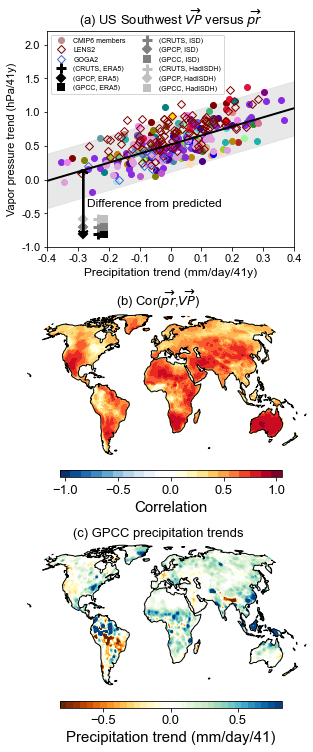

In [17]:
fig = plt.figure(figsize=(3.425,10))

ax = setup_vp_vs_pr(0.0,1,0.67,0.97,'(a) US Southwest $\overrightarrow{VP}$ versus $\overrightarrow{pr}$')

for imodel in np.arange(0,cmip6_vp_trend.model.size,1):
    #datx = cmip6_pr_trend.pr.isel(model=imodel)
    #daty = cmip6_vp_trend.vp.isel(model=imodel)
    datx = cmip6_pr_trend.isel(model=imodel)
    daty = cmip6_vp_trend.vp.isel(model=imodel)
    datx = datx.sel(member=slice(1,nmems[imodel]))
    daty = daty.sel(member=slice(1,nmems[imodel]))
    ax.plot(datx, daty, "o", color=cmip6colors[imodel], label='CMIP6 members' if imodel == 0 else "")
    #ax.plot(datx, daty, "o", color=cmip6colors[imodel])
    
    if (imodel == 0):
        allx = datx.values
        ally = daty.values
    else:
        allx = np.append(allx, datx.values)
        ally = np.append(ally, daty.values)
        
r = np.corrcoef(allx, ally)[0,1]
#ax.text(0.2,1.8, 'r = '+"{0:.2f}".format(r), fontsize=14, color='purple')
        
a, b = linfit.linfit_xy(allx, ally)
residuals = ally - (a + b*allx)
std_residuals = np.std(residuals)

ax.plot(lens2_pr_trend, lens2_vp_trend.vp, "D", markerfacecolor='none', markeredgecolor='maroon', label='LENS2')

ax.plot(goga2_pr_trend, goga2_vp_trend.vp, "D" ,markerfacecolor='none', markeredgecolor='royalblue', label='GOGA2')

xvals = np.arange(-0.4,0.5,0.1)
ax.fill_between(xvals, a + b*xvals - 2*std_residuals, a + b*xvals + 2*std_residuals, color='lightgray', alpha=0.5, zorder=0)
ax.plot(xvals, a + b*xvals, color='black', linewidth=2)

ax.plot(cruts_trend, era5_vp_trend, "+", markerfacecolor='black', markersize=10, markeredgecolor='black', markeredgewidth=3, label='(CRUTS, ERA5)')
ax.plot(gpcp_trend, era5_vp_trend, "D", markerfacecolor='black', markersize=6, markeredgecolor='black', markeredgewidth=2, label='(GPCP, ERA5)')
ax.plot(gpcc_trend, era5_vp_trend, "s", markerfacecolor='black', markersize=6, markeredgecolor='black', markeredgewidth=2, label='(GPCC, ERA5)')

ax.plot(cruts_trend, isd_vp_trend.vp, "+", markerfacecolor='gray', markersize=10, markeredgecolor='gray', markeredgewidth=3, label='(CRUTS, ISD)')
ax.plot(gpcp_trend, isd_vp_trend.vp, "D", markerfacecolor='gray', markersize=6, markeredgecolor='gray', markeredgewidth=2, label='(GPCP, ISD)')
ax.plot(gpcc_trend, isd_vp_trend.vp, "s", markerfacecolor='gray', markersize=6, markeredgecolor='gray', markeredgewidth=2, label='(GPCC, ISD)')

ax.plot(cruts_trend, hadisdh_vp_trend.vp, "+", markerfacecolor='silver', markersize=10, markeredgecolor='silver', markeredgewidth=3, label='(CRUTS, HadISDH)')
ax.plot(gpcp_trend, hadisdh_vp_trend.vp, "D", markerfacecolor='silver', markersize=6, markeredgecolor='silver', markeredgewidth=2, label='(GPCP, HadISDH)')
ax.plot(gpcc_trend, hadisdh_vp_trend.vp, "s", markerfacecolor='silver', markersize=6, markeredgecolor='silver', markeredgewidth=2, label='(GPCC, HadISDH)')
        
    
ax.arrow(gpcp_trend,(a + b*gpcp_trend), 0, era5_vp_trend - (a + b*gpcp_trend), head_width=0.03, color='black', 
         overhang=1, head_starts_at_zero=False, length_includes_head=True, zorder=100, linewidth=2)

ax.arrow(gpcp_trend,era5_vp_trend, 0, (a + b*gpcp_trend) - era5_vp_trend, head_width=0.03, color='black', 
         overhang=1, head_starts_at_zero=False, length_includes_head=True, zorder=100, linewidth=2)

ax.text(-0.27, -0.4, 'Difference from predicted',ha='left', fontsize=12)


ax.legend(loc='upper left', ncol=2, prop={'size': 7})


#-------
ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, cmip6_vp_pr_cor*landfrac, cmip6_vp_pr_cor.lon, cmip6_vp_pr_cor.lat,
                                                            0.1,-1,1,'(b) Cor($\overrightarrow{pr}$,$\overrightarrow{VP}$)',
                                                            -0.15,1.05,0.38,0.58, fontsize=13)
ax = cbars.plotcolorbar(fig, 0.1, -1, 1, 'Correlation',0.05,0.95,0.35,0.36, fsize=13)



ax = mymaps.contourmap_continentsonly_robinson_noborder_pos(fig, gpcc_global*landfrac, gpcc_global.lon, gpcc_global.lat,
                                                            0.05,-0.8,0.8,'(c) GPCC precipitation trends',-0.15,1.05,0.06,0.26, 
                                                            cmap='precip', fontsize=13)
#fig.text(0.535,0.66, '(c) GPCC precipitation trends', ha='center', va='center', fontsize=16)

ax = cbars.plotcolorbar(fig, 0.05, -0.8, 0.8, 'Precipitation trend (mm/day/'+str(nyears)+')',0.05,0.95,0.03,0.04, cmap='precip', fsize=13)


fig.savefig(plotpath+'fig2.pdf', bbox_inches='tight', facecolor='white')